In [1]:
%store -r after_scaler
%store -r out

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, Sequential
from tensorflow import feature_column

c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = out.copy()
df.rename(columns = {'Gender':'gender',	
                     'Age':'age', 
                     'Birth Weight':'birth_weight',
                     'Birth Length' : 'birth_length', 
                     'Body Weight' : 'body_weight', 
                     'Body Length' : 'body_length', 
                     'Breastfeeding':'breastfeeding'},
                     inplace = True)

df.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,breastfeeding,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,2,2,20.230474
1,1,16,2.9,49,66.5,156.2,2,1,42.573624
2,2,11,2.8,49,66.5,185.0,2,2,35.945946
3,2,17,2.8,49,78.1,193.0,2,1,40.466321
4,2,10,2.7,49,68.8,151.0,2,2,45.562914


In [4]:
df.gender[df['gender'] == 2] = 0
df.Stunting[df['Stunting'] == 2] = 0
df.BMI = round(df.BMI, 2)
df.drop('breastfeeding', axis=1, inplace=True)
df.head(1)

C:\Users\KAZU\AppData\Local\Temp\ipykernel_34168\488796399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.gender[df['gender'] == 2] = 0
C:\Users\KAZU\AppData\Local\Temp\ipykernel_34168\488796399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Stunting[df['Stunting'] == 2] = 0


,gender,age,birth_weight,birth_length,body_weight,body_length,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,0,20.23


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size=0.2)

In [32]:
print(len(df_train))
print(len(df_test))
print(len(df_val))

3488
1091
872


In [6]:
stats_train = df_train.describe()
stats_train.pop('Stunting')
stats_train = stats_train.transpose()
stats_train 

,count,mean,std,min,25%,50%,75%,max
gender,3488.0,0.637615,0.480758,0.00,0.00,1.00,1.00,1.0
age,3488.0,12.384461,3.405635,6.00,10.00,12.00,15.00,22.0
birth_weight,3488.0,2.756164,0.298302,2.00,2.80,2.80,3.00,3.1
birth_length,3488.0,49.094610,0.460912,48.00,49.00,49.00,49.00,50.0
body_weight,3488.0,78.733630,29.460636,20.00,54.90,85.10,101.40,120.0
body_length,3488.0,168.197706,19.235623,125.00,156.20,169.00,185.00,193.0
BMI,3488.0,47.530115,18.963443,10.36,34.46,49.53,62.32,96.0


In [8]:
def labels(x):
    stunt = x.pop('Stunting')
    stunt = np.array(stunt)

    return stunt

In [9]:
train_y = labels(df_train)
test_y = labels(df_test)
val_y = labels(df_val)
train_y

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [12]:
df_train.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,BMI
2452,1,10,2.9,49,101.4,185.0,54.81
53,1,14,2.9,48,115.3,169.0,68.22
2242,1,13,2.8,48,31.6,125.0,25.28
4491,1,11,2.9,50,96.7,156.2,61.91
1539,1,11,2.9,48,54.9,151.0,36.36


In [13]:
def norm(x):
    return ((x - stats_train['mean']) / stats_train['std'])

In [15]:
train = norm(df_train)
test = norm(df_test)
val = norm(df_val)
train.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,BMI
2452,0.753779,-0.700152,0.482183,-0.205267,0.769378,0.873499,0.383890
53,0.753779,0.474372,0.482183,-2.374877,1.241194,0.041709,1.091041
2242,0.753779,0.180741,0.146952,-2.374877,-1.599885,-2.245714,-1.173316
4491,0.753779,-0.406521,0.482183,1.964343,0.609843,-0.623723,0.758295
1539,0.753779,-0.406521,0.482183,-2.374877,-0.808999,-0.894055,-0.589034


In [25]:
model = tf.keras.Sequential([
        layers.Input(shape=(7,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

log = model.fit(train, train_y,
                validation_data=(val, val_y),
                epochs=100)

Epoch 1/100
109/109 [==============================] - 1s 2ms/step - loss: 0.4753 - accuracy: 0.8013 - val_loss: 0.4988 - val_accuracy: 0.7706
Epoch 2/100
109/109 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.8122 - val_loss: 0.5054 - val_accuracy: 0.7718
Epoch 3/100
109/109 [==============================] - 0s 1ms/step - loss: 0.4459 - accuracy: 0.8099 - val_loss: 0.4978 - val_accuracy: 0.7649
Epoch 4/100
109/109 [==============================] - 0s 1ms/step - loss: 0.4426 - accuracy: 0.8159 - val_loss: 0.4954 - val_accuracy: 0.7729
Epoch 5/100
109/109 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.8125 - val_loss: 0.4901 - val_accuracy: 0.7661
Epoch 6/100
109/109 [==============================] - 0s 1ms/step - loss: 0.4391 - accuracy: 0.8131 - val_loss: 0.4916 - val_accuracy: 0.7695
Epoch 7/100
109/109 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.8139 - val_loss: 0.4933 - val_accuracy: 0.7695

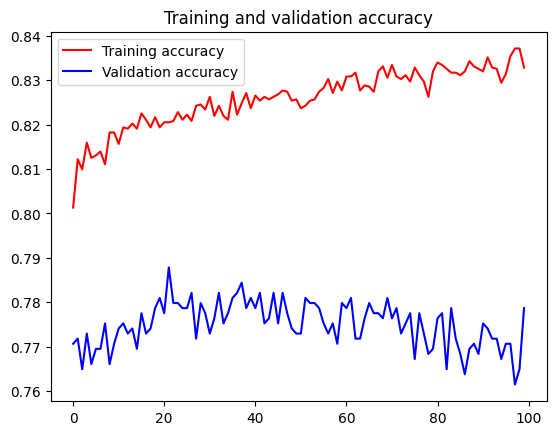

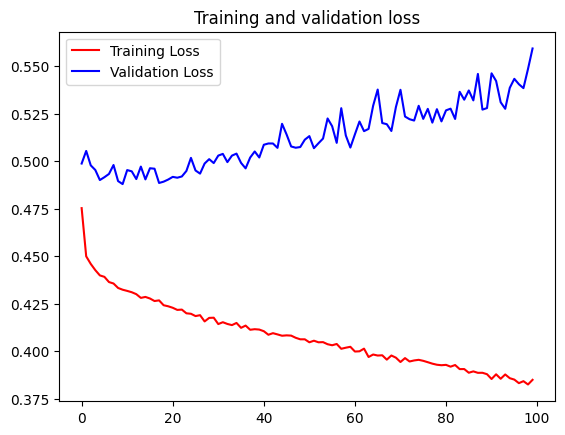

In [26]:
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model.predict(test)

35/35 [==============================] - 0s 628us/step


array([[0.9678474],
       [0.4801728],
       [0.9500042],
       ...,
       [0.9152503],
       [0.3657542],
       [0.8108293]], dtype=float32)

In [ ]:
model.evaluate()